# Adversarial Action Recognition Attack

This notebook demonstrates how to use the ART library to conduct an adversarial attack on video action recognition.

---

First, we are going to show how to use [MXNet](https://mxnet.apache.org/) and [GluonCV](https://gluon-cv.mxnet.io/) for video action recognition. MXNet provides a set of pretrained models for this classification task. In our demonstration we use the pretrained `i3d_resnet50_v1_ucf101` model, which is based on [Carreira and Zisserman '18](https://arxiv.org/abs/1705.07750).

In the following we are going to use a video clip of a **basketball** action taken from the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) data set. Namely, we will show how to correctly classify the following short video clip.


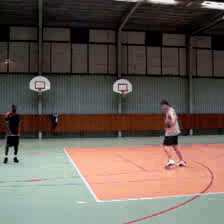


Let's walk through some initial work steps ensuring that the notebook will work smoothly. We will

1. set up a small configuration cell,
2. define some helpful Python functions,
3. download the basketball video sample and load the pretrained action recognition model,
4. and show that the model correctly classifies the video action as playing basketball.


## Load Model and Basketball Sample

In [1]:
import os
import tempfile

from art.attacks import FastGradientMethod
from art.classifiers import MXClassifier
from art.config import ART_DATA_PATH
import decord
from gluoncv import utils
from gluoncv.data.transforms import video
from gluoncv.model_zoo import get_model
from gluoncv.utils.filesystem import try_import_decord
import imageio
from matplotlib.image import imsave
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
import numpy as np

# set global variables
PRETRAINED_MODEL_NAME = 'i3d_resnet50_v1_ucf101'
VIDEO_SAMPLE_URI = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/v_Basketball_g01_c01.avi'

# set seed
np.random.seed(123)

In [2]:
def predict_top_k(video_input, model, k=5, verbose=True):
    """Return top-k class indices."""
    pred = model(nd.array(video_input))
    classes = model.classes    
    ind = nd.topk(pred, k=k)[0].astype('int')
    if verbose:
        msg = "The video sample clip is classified to be"
        for i in range(k):
            msg += f"\n\t[{classes[ind[i].asscalar()]}], with probability {nd.softmax(pred)[0][ind[i]].asscalar():.3f}."
        print(msg)
    return ind


def sample_to_gif(sample, output="sample.gif", path=ART_DATA_PATH, postprocess=None):
    """Convert a numpy video sample of shape 3xFramesxMxN into GIF."""
    frame_count = sample.shape[1]
    output_path = os.path.join(path, output)
    with tempfile.TemporaryDirectory() as tmpdir, imageio.get_writer(output_path, mode='I') as writer:
        for frame in range(frame_count):
            file_path = os.path.join(tmpdir, f"{frame}.png")
            imsave(file_path, np.transpose(sample[:,frame,:,:], (1,2,0)))
            writer.append_data(imageio.imread(file_path))
    return output_path

In [3]:
# download video sample
decord = try_import_decord()
video_fname = utils.download(VIDEO_SAMPLE_URI, path=ART_DATA_PATH);
video_reader = decord.VideoReader(video_fname)
frame_id_list = range(0, 64, 2)
video_data = video_reader.get_batch(frame_id_list).asnumpy()
video_sample_lst = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

# preprocess benign video sample
transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
sample = np.stack(transform_fn(video_sample_lst),  axis=0)
sample = sample.reshape((-1,) + (32, 3, 224, 224))
sample = np.transpose(sample, (0, 2, 1, 3, 4))
print(f"`{video_fname}` has been downloaded and preprocessed.")

`/Users/mathieu/.art/data/v_Basketball_g01_c01.avi` has been downloaded and preprocessed.


In [4]:
# load pretrained model
model = get_model(PRETRAINED_MODEL_NAME, nclass=101, pretrained=True)
print(f"`{PRETRAINED_MODEL_NAME}` model was successfully loaded.")

`i3d_resnet50_v1_ucf101` model was successfully loaded.


In [5]:
# evaluate model on basketball video sample
_ = predict_top_k(sample, model)

The video sample clip is classified to be
	[Basketball], with probability 0.725.
	[TennisSwing], with probability 0.212.
	[VolleyballSpiking], with probability 0.036.
	[SoccerJuggling], with probability 0.012.
	[TableTennisShot], with probability 0.007.


We observe that for the given video sample, the model correctly classified it as playing **basketball**.

## Create Adversarial Attack

We are now ready to employ the ART library and craft an adversarial attack via the Fast Gradient Method. The attack will corrupt the video sample in such a way that it will be misclassified. We will also show how to convert the adversarial example into a GIF as shown below.

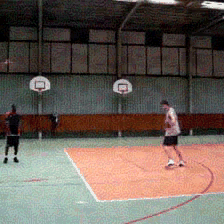

In [6]:
# preprocess adversarial video sample input
transform_fn_unnormalized = video.VideoGroupValTransform(size=224, mean=[0, 0, 0], std=[1, 1, 1])
adv_sample_input = np.stack(transform_fn_unnormalized(video_sample_lst),  axis=0)
adv_sample_input = adv_sample_input.reshape((-1,) + (32, 3, 224, 224))
adv_sample_input = np.transpose(adv_sample_input, (0, 2, 1, 3, 4))

In [7]:
# wrap model in a ART classifier
model_wrapper = gluon.nn.Sequential()
with model_wrapper.name_scope():
    model_wrapper.add(model)

# prepare mean and std arrays for ART classifier preprocessing
mean = np.array([0.485, 0.456, 0.406] * (32 * 224 * 224)).reshape((3, 32, 224, 224), order='F')
std = np.array([0.229, 0.224, 0.225] * (32 * 224 * 224)).reshape((3, 32, 224, 224), order='F')

classifier_art = MXClassifier(
    model=model_wrapper,
    loss=gluon.loss.SoftmaxCrossEntropyLoss(),
    input_shape=(3, 32, 224, 224),
    nb_classes=101,
    preprocessing=(mean, std),
    clip_values=(0, 1),
    channel_index=1,
)

In [8]:
# verify that ART classifier predictions are consistent with original model:
pred = nd.array(classifier_art.predict(adv_sample_input))
ind = nd.topk(pred, k=5)[0].astype('int')

msg = "The video sample clip is classified by the ART classifier to be"
for i in range(len(ind)):
    msg += f"\n\t[{model.classes[ind[i].asscalar()]}], with probability {nd.softmax(pred)[0][ind[i]].asscalar():.3f}."
print(msg)

The video sample clip is classified by the ART classifier to be
	[Basketball], with probability 0.725.
	[TennisSwing], with probability 0.212.
	[VolleyballSpiking], with probability 0.036.
	[SoccerJuggling], with probability 0.012.
	[TableTennisShot], with probability 0.007.


In [9]:
# craft adversarial attack with FGM
epsilon = 8/255
fgm = FastGradientMethod(
    classifier_art,
    eps=epsilon,
)

In [10]:
%%time
adv_sample = fgm.generate(
    x=adv_sample_input,
)

CPU times: user 2min 2s, sys: 2.1 s, total: 2min 4s
Wall time: 1min 54s


In [11]:
# print results
_ = predict_top_k((adv_sample-mean)/std, model)

The video sample clip is classified to be
	[ThrowDiscus], with probability 0.267.
	[Hammering], with probability 0.243.
	[TennisSwing], with probability 0.154.
	[HulaHoop], with probability 0.083.
	[JavelinThrow], with probability 0.055.


In [12]:
adversarial_gif = sample_to_gif(np.squeeze(adv_sample), "adversarial_basketball.gif")
print(f"`{adversarial_gif}` has been successfully created.")

`/Users/mathieu/.art/data/adversarial_basketball.gif` has been successfully created.


## Conclusion
In this notebook we have demonstrated how we can apply the ART library to a video action recognition task. By employing a pretrained MXNet model and loading it via ART's `MXNetClassifier` we can easily plug in several off the shelf attacks like Fast Gradient Method.